In [ ]:
# This tests how we find errors for our calibration program star metallicities, and how we
# find final error bars on our calibration solution coefficients

# created 2018 Jan 14 by E.S.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from astropy.modeling.functional_models import Gaussian2D

In [2]:
# make some fake data representing the metallicities and errors of stars from the literature

fake_data_1 = {"star_name": ["AA Aql","AO Peg","BR Aqr","CI And","DM Cyg","DO Vir","DX Del","X Ari"],
                "feh_lit": [-1.1,-0.6,-1.29,-1.22,-0.69,-0.43,-0.04,-2.51],
                "feh_layden": [-1.05,-0.9,-1.15,-1.2,-0.45,-0.7,0.0,-2.1],
                "err_feh_lit": [0.3,0.3,0.3,0.4,0.2,0.35,0.3,0.4],
                "err_feh_layden": [0.06,0.06,0.07,0.06,0.07,0.06,0.06,0.07]}

fake_dataset_1 = pd.DataFrame(data=fake_data_1)

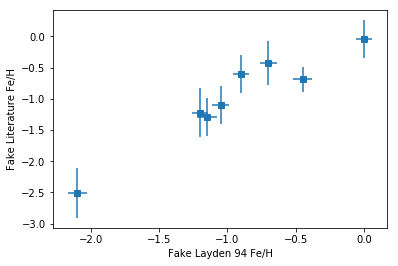

In [27]:
plt.errorbar(fake_data_1["feh_layden"], fake_data_1["feh_lit"], 
             yerr=fake_data_1["err_feh_lit"], xerr=fake_data_1["err_feh_layden"], marker="s", linestyle='')
plt.xlabel("Fake Layden 94 Fe/H")
plt.ylabel("Fake Literature Fe/H")
plt.savefig("fake_data.png")
#plt.show()

# Step 1: Find the linear regression line to high_res vs. basis Fe/H values

In [4]:
test = np.polyfit(fake_data_1["feh_layden"], fake_data_1["feh_lit"], 1)
print(test)

[1.16441617 0.11391776]


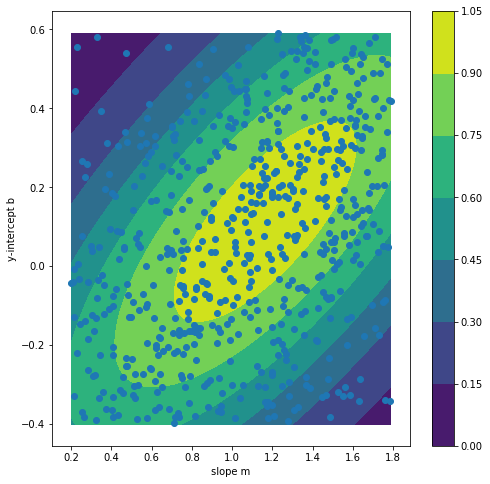

In [25]:
# Gaussian posterior of line parameters, w/ y: y-int, x: slope m

xvalues = np.arange(start = 0.2, stop = 1.8, step = 0.01)
yvalues = np.arange(start = -0.4, stop = 0.6, step = 0.01)

xx, yy = np.meshgrid(xvalues, yvalues)

g2d = Gaussian2D(amplitude=1, 
           x_mean=1.16441617, 
           y_mean=0.11391776, 
           x_stddev=np.sqrt(1.16441617), 
           y_stddev=np.sqrt(0.11391776), 
           theta=35)

plt.figure(figsize = (8,8))
plt.contourf(xx, yy, g2d(xx, yy), origin="lower")
plt.colorbar()
plt.scatter(df_posterior_sample["x_rand_sample"],df_posterior_sample["y_rand_sample"])
plt.xlabel("slope m")
plt.ylabel("y-intercept b")
#plt.savefig("posterior_sample_test.png")
plt.show()

In [6]:
# generate N random points, and keep those below the contour

N = 1000
x_rand_sample = np.random.uniform(low=xvalues[0], high=xvalues[-1], size=N)
y_rand_sample = np.random.uniform(low=yvalues[0], high=yvalues[-1], size=N)
z_rand_sample = np.random.uniform(low=0, high=1, size=N)

df = pd.DataFrame(x_rand_sample, columns=["x_rand_sample"])
df["y_rand_sample"] = y_rand_sample
df["z_rand_sample"] = z_rand_sample

# consider points below the contour
df_posterior_sample = df.where(g2d(df["x_rand_sample"], df["y_rand_sample"]) > df["z_rand_sample"]).dropna().reset_index()

In [28]:
# now draw from the samples of the posterior, and the Gaussian curve around each Layden Fe/H value

# loop over each Layden Fe/H value
for lay in range(0,len(fake_data_1["feh_layden"])):

    mapped_feh_array = np.nan*np.ones(len(df_posterior_sample))
    
    # loop over each sample of the posterior
    for q in range(0,len(df_posterior_sample)):
    
        layden_feh = fake_data_1["feh_layden"][lay]
        
        # draw a Layden 94 FeH within the error he gives 
        layden_feh_sample = layden_feh*(1. + np.random.normal(loc=0.0, scale=fake_data_1["err_feh_layden"][lay] ))
        
        # make a mapped FeH for each combination of 
        # slope
        # y-intercept
        # FeH from Layden 94 (his value plus error)
        mapped_feh = layden_feh_sample*df_posterior_sample["x_rand_sample"][q] + df_posterior_sample["y_rand_sample"][q]
        mapped_feh_array[q] = mapped_feh
        #print(layden_feh_sample)
        
    plt.hist(mapped_feh_array, bins = 100)
    plt.title("Layden Fe/H: "+str(layden_feh_sample)+
              "\n median: "+str(np.median(mapped_feh_array))+
              "\n mean: "+str(np.mean(mapped_feh_array))+
              "\n stdev: "+str(np.std(mapped_feh_array)))
    plt.tight_layout()
    plt.savefig("fake_mapped_"+str(lay)+".png")
    plt.clf()

<Figure size 432x288 with 0 Axes>

# Step 2: Find the remapping of literature metallicities, with errors

# Step 3: Find the calibration coefficients (a,b,c,d) with errors